In [ ]:
# Please run this cell only if you are using Google Colab.

# install required dependencies
# import sys
# IN_COLAB = 'google.colab' in sys.modules
# if IN_COLAB:

!pip install -q pyomo
!apt-get install -y -qq glpk-utils
!apt-get install -y -qq coinor-cbc
!wget -N -q "https://github.com/thomasfork/ipopt_linux/raw/main/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64
!pip install polytope

import polytope as pt
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [ ]:
def minkowski_sum(X, Y):

    # Minkowski sum between two polytopes based on
    # vertex enumeration. So, it's not fast for the
    # high dimensional polytopes with lots of vertices.
    V_sum = []
    if isinstance(X, pt.Polytope):
        V1 = pt.extreme(X)
    else:
        # assuming vertices are in (N x d) shape. N # of vertices, d dimension
        V1 = X

    if isinstance(Y, pt.Polytope):
        V2 = pt.extreme(Y)
    else:
        V2 = Y

    for i in range(V1.shape[0]):
        for j in range(V2.shape[0]):
            V_sum.append(V1[i,:] + V2[j,:])
    return pt.qhull(np.asarray(V_sum))

def precursor(Xset, A, Uset=pt.Polytope(), B=np.array([])):
        if not B.any():
            return pt.Polytope(Xset.A @ A, Xset.b)
        else:
            tmp  = minkowski_sum( Xset, pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)

def Oinf(Xset, A, Wset=pt.Polytope()):
    Omega = Xset
    k = 0
    max_iteration = 50
    Omegap = precursor(Omega, A).intersect(Omega)
    while (not Omegap == Omega) and k <= max_iteration:
        #plot_proj(Omegap)
        k += 1
        Omega = Omegap
        if not pt.is_empty(Wset):
            Omegap = pt.reduce(precursor(Omega, A, Wset=Wset).intersect(Omega))
        else:
            Omegap = pt.reduce(precursor(Omega, A).intersect(Omega))
    return Omegap



In [ ]:
#Function to plot the projection of a polytope in plans (psi,psidot) and (x,xdot):
from scipy.spatial import ConvexHull

def plot_proj(X):
  vertices = pt.extreme(X)
  vertices_psi = vertices[:,[0,2]]
  vertices_x = vertices[:,[1,3]]

  hull_psi = ConvexHull(vertices_psi)
  polytope_vertices_psi = vertices_psi[hull_psi.vertices, :]
  X_psi = pt.qhull(polytope_vertices_psi)

  hull_x = ConvexHull(vertices_x)
  polytope_vertices_x = vertices_x[hull_x.vertices, :]
  X_x = pt.qhull(polytope_vertices_x)

# Plot the projection
  fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the projections
  X_psi.plot(axs[0])
  X_x.plot(axs[1])
  axs[0].set_xlabel('ψ')
  axs[0].set_ylabel('ψ dot')
  axs[0].autoscale_view()
  axs[0].axis('equal')

  axs[1].set_xlabel('x')
  axs[1].set_ylabel('x dot')
  axs[1].autoscale_view()
  axs[1].axis('equal')

  plt.tight_layout()
  plt.show()

In [ ]:
#System params
Ts = 2
F = 1177200 # [KN] this ensures vertical acc. = 0
m = 120000
L = 50
r = 4.5
I = .25*m*r**2 + (1/12)*m*L**2
g = 9.81

#MPC parameters
R = 10
Q = np.diag([1000,0,10,5])
N = 7     # play around with this
P = Q

#Bounds
zL = np.array([[-15],[-1000],[-10],[-1000]])
zU = np.array([[15],[1000],[10],[1000]])
uL = -15
uU = 15

# Constraint sets represented as polyhedra
# Number of dimensions
n = zL.shape[0]

# Construct the A matrix and b vector
matXA = np.vstack((np.eye(n), -np.eye(n)))
matXb = np.vstack((zU, -zL))

# Flatten b for easier visualization
matXA, matXb.flatten()
X = pt.Polytope(matXA, matXb)

U = pt.Polytope(np.array([1, -1]).reshape(2,1),
                np.array([uU, uU]).reshape(2,1))

A = np.eye(4)
A[0,2]=Ts
A[1,3]=Ts
A[3,0]=-Ts*(F/m)*np.pi/180

B = np.array([[0], [0], [-Ts*F*(L/(2*I))*np.pi/180], [-Ts*(F/m)*np.pi/180]])

In [ ]:
import numpy as np
import pyomo.environ as pyo
from pyomo.opt import SolverStatus, TerminationCondition

def cftoc(zbar0, N, P, Af = np.nan, bf=np.nan):

    model = pyo.ConcreteModel()
    model.N = N
    model.nz = np.size(A, 0)
    model.nu = np.size(B, 1)

    if isinstance(Af, float) and np.isnan(Af):
        model.nf = 0
        Af = np.empty((0, model.nz))  # Empty array with correct shape
    else:
        model.nf = np.size(Af, 0)

    if isinstance(bf, float) and np.isnan(bf):
        bf = np.empty(model.nf)  # Empty array with length model.nf

    # length of finite optimization problem:
    model.tIDX = pyo.Set( initialize= range(model.N+1), ordered=True )
    model.zIDX = pyo.Set( initialize= range(model.nz), ordered=True )
    model.uIDX = pyo.Set( initialize= range(model.nu), ordered=True )
    model.nfIDX = pyo.Set( initialize= range(model.nf), ordered=True )

    # these are 2d arrays:
    model.A = A
    model.B = B
    model.Q = Q
    model.P = P
    model.R = R
    model.Af = Af
    model.bf = bf

    # Create state and input variables trajectory:
    def z_bounds(model, i, t):
      return (zL[i,0], zU[i,0])

    model.z = pyo.Var(model.zIDX, model.tIDX, bounds=z_bounds)
    model.u = pyo.Var(model.uIDX, model.tIDX, bounds=(uL,uU))

    #Objective:
    def objective_rule(model):
        costX = 0.0
        costU = 0.0
        costTerminal = 0.0
        for t in model.tIDX:
            for i in model.zIDX:
                for j in model.zIDX:
                    if t < model.N:
                        costX += model.z[i, t] * model.Q[i, j] * model.z[j, t]
        for t in model.tIDX:
            for i in model.uIDX:
                for j in model.uIDX:
                    if t < model.N:
                        costU += model.u[i, t] * model.R * model.u[j, t]
        for i in model.zIDX:
            for j in model.zIDX:
                costTerminal += model.z[i, model.N] * model.P[i, j] * model.z[j, model.N]
        return costX + costU + costTerminal

    model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)

    # Constraints:
    def equality_const_rule(model, i, t):
        return model.z[i, t+1] - (sum(model.A[i, j] * model.z[j, t] for j in model.zIDX)
                               +  sum(model.B[i, j] * model.u[j, t] for j in model.uIDX) ) == 0.0 if t < model.N else pyo.Constraint.Skip

    model.equality_constraints = pyo.Constraint(model.zIDX, model.tIDX, rule=equality_const_rule)
    model.init_const1 = pyo.Constraint(expr = model.z[0, 0] == zbar0[0])
    model.init_const2 = pyo.Constraint(expr = model.z[1, 0] == zbar0[1])
    model.init_const3 = pyo.Constraint(expr = model.z[2, 0] == zbar0[2])
    model.init_const4 = pyo.Constraint(expr = model.z[3, 0] == zbar0[3])

    def final_const_rule(model, i):
      if model.nf > 0:
        return sum(model.Af[i, j] * model.z[j, model.N] for j in model.zIDX) <= model.bf[i]
      else:
          return pyo.Constraint.Skip

    model.final_const = pyo.Constraint(model.nfIDX, rule=final_const_rule)

    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)

    if str(results.solver.termination_condition) == "optimal":
        is_optimal = True
    else:
        is_optimal = False

    zOpt = np.asarray([[model.z[i,t]() for i in model.zIDX] for t in model.tIDX]).T
    uOpt = np.asarray([model.u[:,t]() for t in model.tIDX]).T[0]

    JOpt = model.cost()

    return zOpt, uOpt, is_optimal



In [ ]:
def sim_mpc(z0,N,Af,bf,P):
  #Simulation time
  M = 30
  #### Initialize ###
  nz = 4
  nu = 1
  zOpt = np.zeros((nz, M+1))
  uOpt = np.zeros((nu, M))
  zOpt[:, 0] = z0.reshape(nz, )
  feas = np.zeros((M, ), dtype=bool)
  zN = np.zeros((nz,1))
  infeas_flag = False
  ###################

  fig = plt.figure(figsize=(9, 6))

  #MPC Closed-loop simulation
  for time in range(M):

      [z, a, feas[time]] = cftoc(zOpt[:, time],N,P,Af,bf)

      if not feas[time]:
          zOpt[:,time] = np.nan
          uOpt[:,time] = np.nan
          infeas_flag = True
          break
      # Save closed loop trajectory
      # Note that the second column of x represents the optimal closed loop state
      zOpt[:, time+1] = z[:,1]
      uOpt[:, time] = a[0]

      # Plot Open Loop
      line1 = plt.plot(z[0,:], z[2,:], 'b--')

  #Print/plot results
  if infeas_flag:
    print(feas) #You may see a plot with some openloop trajectories even when the MPC is not recursively feasible. Ignore this figure.
  else:
    print(feas)
    # Plot Closed Loop and Openloop trajectories
    line2 = plt.plot(zOpt[0, :], zOpt[2, :], 'go-')
    plt.legend([line1[0], line2[0]], ['Open-loop', 'Closed-loop']);
    plt.xlabel('psi (deg)')
    plt.ylabel('omega (deg/s)')
    plt.axis('equal')
    plt.show()

  return zOpt,uOpt


In [ ]:
#Terminal set definition
eps_psi=0
eps_ome=1
eps_v=100
xU=200
xL=-200

#Construct the Af and bf
Af = np.array([[1,0,0,0],[-1,0,0,0],[0,1,0,0],[0,-1,0,0],[0,0,1,0],[0,0,-1,0],[0,0,0,1],[0,0,0,-1]])
bf = np.array([eps_psi,eps_psi,xU,-xL,eps_ome,eps_ome,eps_v,eps_v]).T

Xf= pt.Polytope(Af,bf)

In [ ]:
#Computation of X0
C={}
PreS = precursor(Xf,A,U,B)
for k in range (N):
  C[k]=PreS.intersect(X)
  PreS = precursor(C[k],A,U,B)

X0 = C[N-1]

plot_proj(X0)

AttributeError: ignored

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


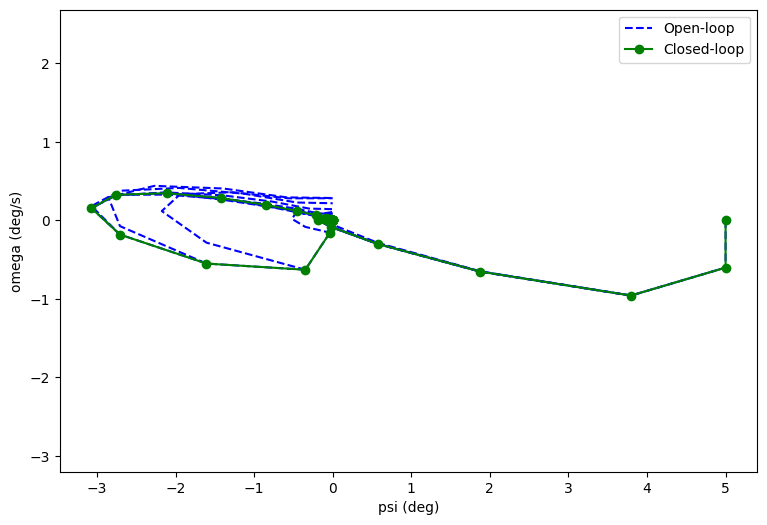

In [ ]:
#Execution
zbar0 = np.array([5,0,0,0]).T
zOpt,uOpt = sim_mpc(zbar0,N,Af,bf,P)

In [ ]:
import numpy as np

def compute_controllability_matrix_and_rank(A, B):
    """
    Compute the controllability matrix for a given system (A, B)
    and determine its rank.

    Parameters:
    A (numpy.ndarray): The state matrix of the system.
    B (numpy.ndarray): The input matrix of the system.

    Returns:
    tuple: Controllability matrix and its rank.
    """
    n = A.shape[0]
    controllability_mat = B

    for i in range(1, n):
        controllability_mat = np.hstack((controllability_mat, np.linalg.matrix_power(A, i) @ B))

    rank = np.linalg.matrix_rank(controllability_mat)
    return controllability_mat, rank

# Replace with your actual A and B matrices

controllability_matrix, controllability_rank = compute_controllability_matrix_and_rank(A, B)
print("Controllability Matrix:\n", controllability_matrix)
print("Rank of Controllability Matrix:", controllability_rank)

Controllability Matrix:
 [[ 0.      -0.08023 -0.16047 -0.2407 ]
 [ 0.      -0.68487 -1.36973 -1.99965]
 [-0.04012 -0.04012 -0.04012 -0.04012]
 [-0.34243 -0.34243 -0.31496 -0.26001]]
Rank of Controllability Matrix: 4


Text(0.5, 1.0, 'Evolution of $\\theta$')

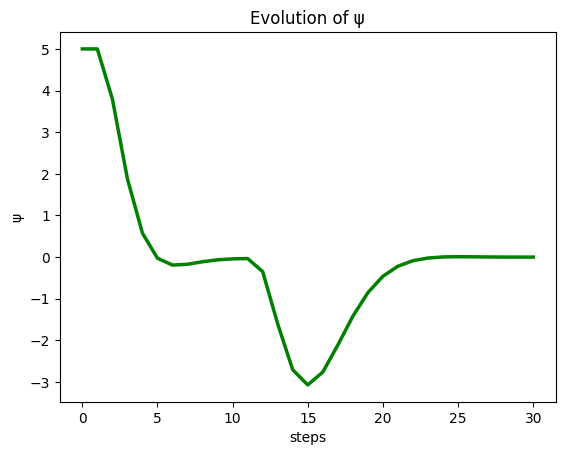

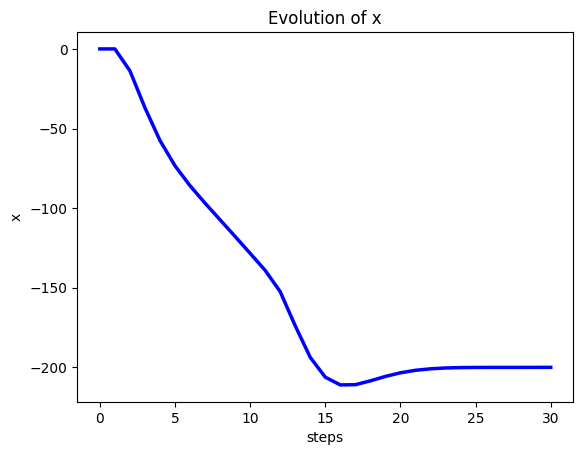

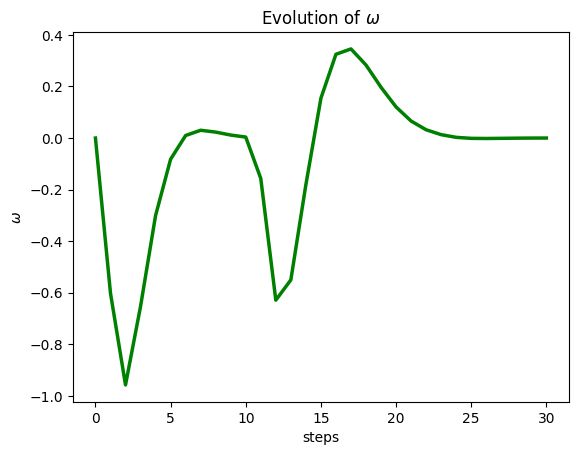

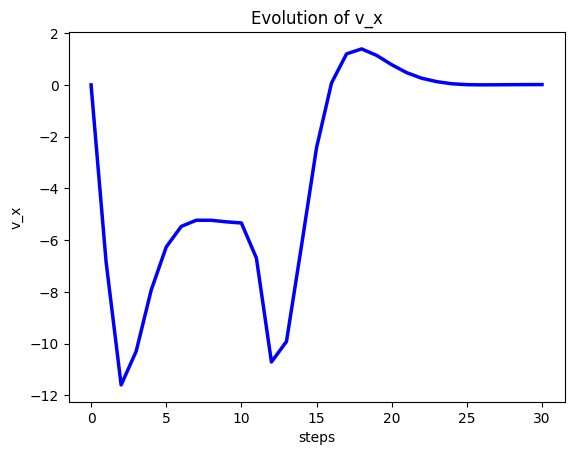

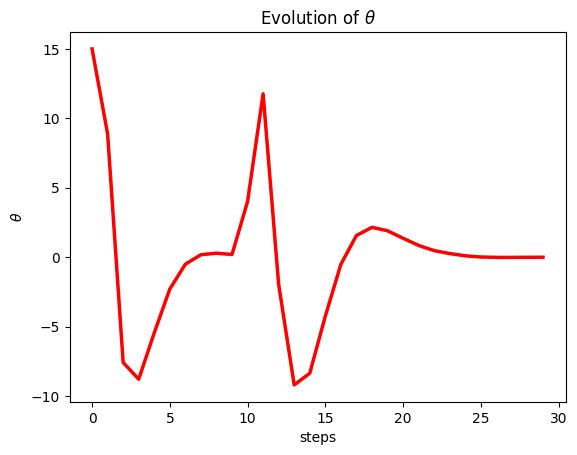

In [ ]:
# Plot Evolution of states in time
plt.figure(1)
steps = np.arange(0,31)
plt.plot(steps,zOpt[0],'g',lw = 2.5)
plt.xlabel('steps')
plt.ylabel('ψ')
plt.axis('auto')
plt.title('Evolution of ψ')

plt.figure(2)
plt.plot(steps,zOpt[1],'b',lw = 2.5)
plt.xlabel('steps')
plt.ylabel('x')
plt.axis('auto')
plt.title('Evolution of x')

plt.figure(3)
plt.plot(steps,zOpt[2],'g',lw = 2.5)
plt.xlabel('steps')
plt.ylabel(r'$\omega$')
plt.axis('auto')
plt.title('Evolution of 'r'$\omega$')

plt.figure(4)
plt.plot(steps,zOpt[3],'b',lw = 2.5)
plt.xlabel('steps')
plt.ylabel('v_x')
plt.axis('auto')
plt.title('Evolution of v_x')

plt.figure(5)
plt.plot(steps[:-1],uOpt[0],'r',lw = 2.5)
plt.xlabel('steps')
plt.ylabel(r'$\theta$')
plt.axis('auto')
plt.title('Evolution of ' r'$\theta$')

Text(0.5, 1.0, 'Trajectory of the rocket during stabilization')

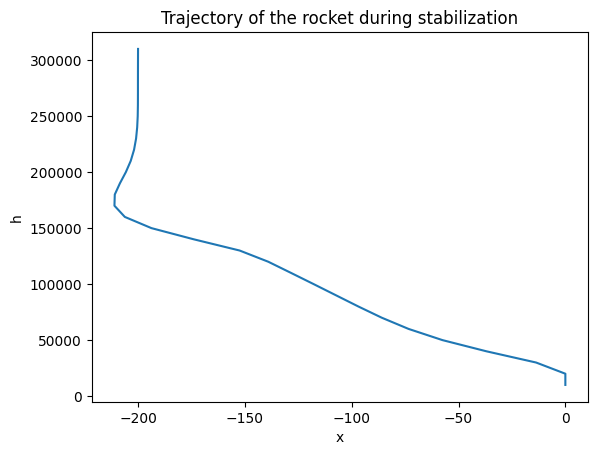

In [ ]:
#Trajectory in plane (x,z)
#We assume constant vertical velocity
h = np.linspace(10000,310000,31)
plt.plot(zOpt[1],h)
plt.xlabel('x')
plt.ylabel('h')
plt.axis('auto')
plt.title('Trajectory of the rocket during stabilization')